In [51]:
import os
import urllib.request
import numpy as np
import torch
import torch.utils.data
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.io import loadmat

class MNIST():
    def __init__(self, batch_size, binarize=False, logit_transform=False):
        """ [-1, 1, 28, 28] """
        self.binarize = binarize
        self.logit_transform = logit_transform
        self.lamb = 0.05
        directory='./datasets/MNIST'
        if not os.path.exists(directory):
            os.makedirs(directory)

        kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
        self.train_loader = DataLoader(
            datasets.MNIST('./', train=True, download=False,
                           transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=True, **kwargs)

        self.test_loader = DataLoader(
            datasets.MNIST('./', train=False, transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=False, **kwargs)

        self.dim = [1,28,28]

        if self.binarize:
            pass
        else:
            train = torch.stack([data for data, _ in
                                 list(self.train_loader.dataset)], 0).cuda()
            train = train.view(train.shape[0], -1)
            if self.logit_transform:
                train = train * 255.0
                train = (train + torch.rand_like(train)) / 256.0
                train = self.lamb + (1 - 2.0 * self.lamb) * train
                train = torch.log(train) - torch.log(1.0 - train)

            self.mean = train.mean(0)
            self.logvar = torch.log(torch.mean((train - self.mean)**2)).unsqueeze(0)

    def preprocess(self, x):
        if self.binarize:
            x = x.view([-1, np.prod(self.dim)])
            return (torch.rand_like(x).cuda() < x).to(torch.float)
        elif self.logit_transform:
            # apply uniform noise and renormalize
            x = x.view([-1, np.prod(self.dim)]) * 255.0
            x = (x + torch.rand_like(x)) / 256.0
            x = self.lamb + (1 - 2.0 * self.lamb) * x
            x = torch.log(x) - torch.log(1.0 - x)
            return x - self.mean
        else:
            return x.view([-1, np.prod(self.dim)])# - self.mean

    def unpreprocess(self, x):
        if self.binarize:
            return x.view([-1] + self.dim)
        elif self.logit_transform:
            x = x + self.mean
            x = torch.sigmoid(x)
            x = (x - self.lamb) / (1.0 - 2.0 * lamb)
            return x.view([-1] + self.dim)
        else:
            return (x + self.mean).view([-1] + self.dim)

In [52]:
# load MNIST dataset
BATCH_SIZE = 64
mnist = MNIST(batch_size=BATCH_SIZE, logit_transform=True)
data = mnist.train_loader

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class BaseEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = latent_dim
        self.x_dim = 784
        self.h_dim = hidden_dim
        self.linear_hidden0 = nn.Linear(self.x_dim, self.h_dim)
        if layers > 1:
            self.linear_hidden1 = nn.Linear(self.h_dim, self.h_dim)
        self.linear_mu = nn.Linear(self.h_dim, self.z_dim)
        self.linear_logvar = nn.Linear(self.h_dim, self.z_dim)
        self.activation = F.relu

    def forward(self, x):
        h = self.activation(self.linear_hidden0(x))
        if layers > 1:
            h = self.activation(self.linear_hidden1(h))
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        return DiagonalGaussian(mu, logvar), h

class BaseDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = latent_dim
        self.x_dim = 784
        self.h_dim = hidden_dim
        self.linear_hidden0 = nn.Linear(self.z_dim, self.h_dim, bias=False)
        if layers > 1:
            self.linear_hidden1 = nn.Linear(self.h_dim, self.h_dim, bias=False)
        self.linear_mu = nn.Linear(self.h_dim, self.x_dim, bias=False)
        self.activation = F.relu
        self.logvar = torch.Tensor([0.0]).cuda() # decoder output variance # todo fix device

    def forward(self, z, compute_jacobian=False):
        if compute_jacobian:
            h = self.activation(self.linear_hidden0(z))
            activation_mask = torch.unsqueeze(h > 0.0, dim=-1).to(torch.float) # [batch_size, hidden_dim, 1]
            W = self.linear_hidden0.weight # [hidden_dim, input_dim]
            W = activation_mask * W # [batch_size, hidden_dim, input_dim]
            
            if layers > 1:
                h = self.activation(self.linear_hidden1(h))
                activation_mask = torch.unsqueeze(h > 0.0, dim=-1).to(torch.float)
                W = torch.matmul(self.linear_hidden1.weight, W)
                W = activation_mask * W

            W = torch.matmul(self.linear_mu.weight, W)
            mu = self.linear_mu(h)
            W_out = W
            return DiagonalGaussian(mu, self.logvar.detach()), W_out

        else:
            h = self.activation(self.linear_hidden0(z))
            if layers > 1:
                h = self.activation(self.linear_hidden1(h))
            mu = self.linear_mu(h)
            return DiagonalGaussian(mu, self.logvar.detach())


class DiagonalGaussian():
    def __init__(self, mu, logvar):
        self.mu = mu
        self.logvar = logvar

    def log_probability(self, x):
        return -0.5 * torch.sum(np.log(2.0*np.pi) + self.logvar + ((x - self.mu)**2)
                                    / torch.exp(self.logvar), dim=1)

    def sample(self):
        eps = torch.randn_like(self.mu)
        return self.mu + torch.exp(0.5 * self.logvar) * eps

    def repeat(self, n):
        mu = self.mu.unsqueeze(1).repeat(1, n, 1).view(-1, self.mu.shape[-1])
        logvar = self.logvar.unsqueeze(1).repeat(1, n, 1).view(-1, self.logvar.shape[-1])
        return DiagonalGaussian(mu, logvar)

    @staticmethod
    def kl_div(p, q):
        return 0.5 * torch.sum(q.logvar - p.logvar - 1.0 + (torch.exp(p.logvar) + (p.mu - q.mu)**2)/(torch.exp(q.logvar)), dim=1)

class VAE(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.image_size = 784
        self.encoder = BaseEncoder()
        self.decoder = BaseDecoder()
        self.prior = DiagonalGaussian(mu=torch.zeros(1,1).cuda(), logvar=torch.zeros(1,1).cuda())

    def forward(self, x):
        q_z_x, _ = self.encoder(x) # returns distribution
        z = q_z_x.sample()
        p_x_z = self.decoder(z)
        return self.loss(x, z, p_x_z, self.prior, q_z_x)

    def loss(self, x, z, p_x_z, p_z, q_z_x, complexity=True):
        self.error_p_x_z = p_x_z.log_probability(x.view(-1, self.image_size)) # prediction error
        self.error_p_z = p_z.log_probability(z) # complexity wrt. prior distribution
        self.error_q_z_x = q_z_x.log_probability(z) # complexity wrt. posterior distribution
        self.kl_from_logvar = -(self.error_p_z - self.error_q_z_x)
        if complexity:
            self.ELBO = -torch.mean(self.error_p_x_z + (self.error_p_z - self.error_q_z_x))
        else:
            self.ELBO = -torch.mean(self.error_p_x_z)
        #self.kl = DiagonalGaussian.kl_div(q_z_x, p_z)
        #self.ELBO = -torch.mean(self.error_p_x_z - self.kl)
        return self.ELBO



In [133]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        x = mnist.preprocess(x.to(device))
        z = autoencoder.encoder(x.view([-1,784]))[0].mu
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.mu.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

In [206]:
class Gaussian():
    def __init__(self, mu, precision):
        self.mu = mu #[batch_size, z_dim]
        self.precision = precision # [batch_size, z_dim, z_dim]
        self.L = torch.linalg.cholesky(torch.inverse(precision)) # TODO: get rid of the inverse for efficiency
        self.dim = self.mu.shape[1]

    def log_probability(self, x):
        indices = np.arange(self.L.shape[-1])
        return -0.5 * (self.dim * np.log(2.0*np.pi)
                       + 2.0 * torch.log(self.L[:, indices, indices]).sum(1)
                       + torch.matmul(torch.matmul((x - self.mu).unsqueeze(1), self.precision),
                                      (x - self.mu).unsqueeze(-1)).sum([1, 2]))

    def sample(self):
        eps = torch.randn_like(self.mu)
        return self.mu + torch.matmul(self.L, eps.unsqueeze(-1)).squeeze(-1)

    def repeat(self, n):
        mu = self.mu.unsqueeze(1).repeat(1, n, 1).view(-1, self.mu.shape[-1])
        precision = self.precision.unsqueeze(1).repeat(1, n, 1, 1).view(-1, *self.precision.shape[1:])
        return Gaussian(mu, precision)

class VLAE(VAE):
    def __init__(self, z_dim=2, decode_mode=False, use_error=False, 
                 seek_mode=True, steps=1, seek_prior=False, seek_encoded=False):
        super().__init__(z_dim)
        self.n_update = steps # iterative inference (mode seeking) steps
        self.update_lr = .5
        self.image_size = 784
        self.seek_mode = seek_mode # iterative inference
        self.decode_mode = decode_mode # sample before decoding or use the mode
        self.use_error = use_error # use prediction errors or observation for mode seeking
        self.seek_encoded = seek_encoded

    def solve_mu(self, x, mu_prev, p_x_z, q_z_x, W_dec, use_error=False):

        # reverse propagation of observation (VLAE)
        if not use_error:
            # state precision (squared jacobian)
            var_inv = torch.exp(-self.decoder.logvar).unsqueeze(1) # decoder output variance (constant 1)
            precision = torch.matmul(W_dec.transpose(1, 2) * var_inv, W_dec) # variance = squared jacobian, weighted by predicted variance
            precision += torch.eye(precision.shape[1]).unsqueeze(0).cuda() # variance + damping
        
            mu = torch.matmul(W_dec.transpose(1, 2), x.view(-1, self.image_size, 1)) # could additionally be weighted by variance at decoder output, see original VLAE implementation
            mu = torch.matmul(torch.inverse(precision), mu).squeeze(-1)
            return mu, precision
        else: # reverse propagation of prediction error (PC)
            
            # state precision 
            var_inv = torch.exp(-self.decoder.logvar).unsqueeze(1) # decoder output variance (constant 1)
            precision = torch.matmul(W_dec.transpose(1, 2) * var_inv, W_dec) # variance = squared jacobian, weighted by predicted variance
            precision += torch.eye(precision.shape[1]).unsqueeze(0).cuda() # variance + damping
        
            # optimize towards observation (accuracy)
            error = (p_x_z.mu - x.view(p_x_z.mu.shape)).unsqueeze(-1) # prediction error  (observation - prediction)
            change = torch.matmul(W_dec.transpose(1, 2), error) 
            mu_prev = mu_prev - torch.matmul(torch.inverse(precision), change).squeeze(-1)

            # optimize towards encoded cause (complexity)
            if self.seek_encoded: 
                error_encoded = -torch.matmul(torch.inverse(q_z_x.precision), (q_z_x.mu - mu_prev).unsqueeze(-1)).squeeze(-1) # prediction error (encoded cause - inferred cause)
                mu_prev = mu_prev - torch.matmul(torch.inverse(precision), error_encoded.unsqueeze(-1)).squeeze(-1)

            return mu_prev, precision

    def update_rate(self, t):
        return self.update_lr / (t+1)
    
    def forward(self, x):
        q_z_x, _ = self.encoder.forward(x) # amortized inference
        if self.use_error: # predictive coding
            mu = q_z_x.mu.detach()# *0 + 0.00001 # zero initialisation
            mu_encoded = q_z_x.mu
        else: # joint encoder/decoder training
            mu = q_z_x.mu

        # mode seeking (iterative inference)
        if self.seek_mode:
            
            # compute precision of prior
            if self.use_error:
                p_x_z, W_dec = self.decoder.forward(mu, compute_jacobian=True)
                precision = torch.matmul(W_dec.transpose(1, 2), W_dec)
                precision += torch.eye(precision.shape[1]).unsqueeze(0).cuda()
                q_z_x = Gaussian(mu, precision)
                precision_encoded = precision
            
            for i in range(self.n_update):
                p_x_z, W_dec = self.decoder.forward(mu, compute_jacobian=True)
                mu_new, precision = self.solve_mu(x, mu, p_x_z, q_z_x, W_dec, use_error=self.use_error)
                lr = self.update_rate(i)
                mu = (1 - lr) * mu + lr * mu_new

            # compute prediction at mode
            p_x_z, W_dec = self.decoder.forward(mu, compute_jacobian=True)
            precision = torch.matmul(W_dec.transpose(1, 2), W_dec)
            precision += torch.eye(precision.shape[1]).unsqueeze(0).cuda()
            q_z_x = Gaussian(mu, precision)
            
        # either sample or use the mode directly for decoding
        if self.decode_mode:
            z = mu
        else:
            z = q_z_x.sample()
        p_x_z = self.decoder.forward(z)

        if self.use_error: # predictive coding
            # with complexity = False (no cause Prior), PCN still optimises towards N(0,1) when zero-initialised, but needs more steps to get high accuracy values
            q_z_x_encoded = Gaussian(mu_encoded, precision_encoded)
            encoder_error = -q_z_x_encoded.log_probability(mu).mean() # todo z or mu?

            return self.loss(x, z, p_x_z, self.prior, q_z_x, complexity=True) + encoder_error
        else: # joint encoder/decoder training
            return self.loss(x, z, p_x_z, self.prior, q_z_x)
    

In [207]:
# model settings
hidden_dim = 256 # size of hidden layers
layers = 2 # one or two hidden layers 
inference_steps = 1 # iterative inference (mode seeking) steps 

# training settings
epochs = 1
max_batches = None # batches per epoch, None for full dataset

In [208]:
def train(model, data, epochs=1, max_batches=max_batches, optimiser="Adam"):
    if optimiser == "Adam":
        print("Adam optimizer")
        opt = torch.optim.Adam(model.parameters())
    elif optimiser == "SGD":
        print("SGD optimizer")
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.)
    else:
        print("No valid optimiser selected. Using SGD.")
    losses, losses_error, losses_posterior = [],[],[]
    for epoch in range(epochs):
        print("Epoch", epoch)
        for batch, (x, y) in enumerate(data):
            x = mnist.preprocess(x.to(device)).view([-1,784])
            opt.zero_grad()
            loss = model(x)
            loss.backward()
            opt.step()
            
            ELBO = -torch.mean(model.error_p_x_z + (model.error_p_z - model.error_q_z_x))
            losses.append(ELBO.item())
            losses_error.append(-model.error_p_x_z.mean().item())
            losses_posterior.append(model.kl_from_logvar.mean().item())
            if max_batches is not None:
                if batch == max_batches: break
    return model, [losses, losses_error, losses_posterior]

def train_all(optimiser="Adam", inspect=False):
    models = []
    
    # Vanilla VAE
    if inspect:

        # VPCN (reverse prop of error, sampling before decoder)
        print("\nTraining VPCN")
        vae = VLAE(decode_mode=False, use_error=True, steps=inference_steps, seek_encoded=True).to(device) 
        vae, losses_vlae_PC_sampling = train(vae, data, epochs=epochs, optimiser=optimiser)
        if latent_dim == 2:
            plot_latent(vae, data)
            plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))
        models.append(vae)
    else:
        print("\nTraining VAE")
        vae = VAE().to(device) 
        vae, losses_vae = train(vae, data, epochs=epochs, optimiser=optimiser)
        if latent_dim == 2:
            plot_latent(vae, data)
            plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))
        models.append(vae)
        
        # VLAE (reverse prop of observation, sampling before decoder)
        print("\nTraining VLAE")
        vae = VLAE(decode_mode=False, use_error=False, steps=inference_steps).to(device) 
        vae, losses_vlae = train(vae, data, epochs=epochs, optimiser=optimiser)
        if latent_dim == 2:
            plot_latent(vae, data)
            plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))
        models.append(vae)

        # PCN (reverse prop of error, no sampling before decoder)
        print("\nTraining PCN")
        vae = VLAE(decode_mode=True, use_error=True, steps=inference_steps, seek_encoded=False).to(device) 
        vae, losses_vlae_PC_mode = train(vae, data, epochs=epochs, optimiser=optimiser)
        if latent_dim == 2:
            plot_latent(vae, data)
            plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))
        models.append(vae)

        # VPCN (reverse prop of error, sampling before decoder)
        print("\nTraining VPCN")
        vae = VLAE(decode_mode=False, use_error=True, steps=inference_steps, seek_encoded=False).to(device) 
        vae, losses_vlae_PC_sampling = train(vae, data, epochs=epochs, optimiser=optimiser)
        if latent_dim == 2:
            plot_latent(vae, data)
            plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))
        models.append(vae)
    
    # plot loss
    for pos, title in enumerate(["ELBO", "Bottom-up prediction error (Accuracy)", 
                                 "Top-down prediction error (Complexity KLD)"]):
        plt.rcParams['figure.dpi'] = 100
        if inspect:
            #plt.plot(losses_vlae[pos], label="VLAE") # vanilla VAE
            plt.plot(losses_vlae_PC_sampling[pos], label="VPCN") # vanilla VAE
        else:
            plt.plot(losses_vae[pos], label="VAE") # vanilla VAE
            plt.plot(losses_vlae[pos], label="VLAE") # VLAE (reverse prop of observation, sampling before decoder)
            plt.plot(losses_vlae_PC_mode[pos], label="PCN") # VLAE (reverse prop of error, no sampling before decoder)
            plt.plot(losses_vlae_PC_sampling[pos], label="VPCN") # VLAE (reverse prop of error, sampling before decoder)
        plt.legend();  plt.title(f"{title}"); plt.grid(); plt.show()
        
    return models

    


Training VAE
Adam optimizer
Epoch 0


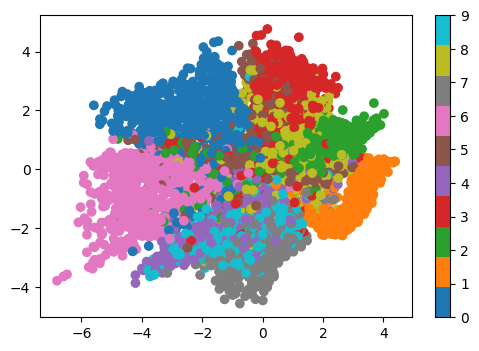

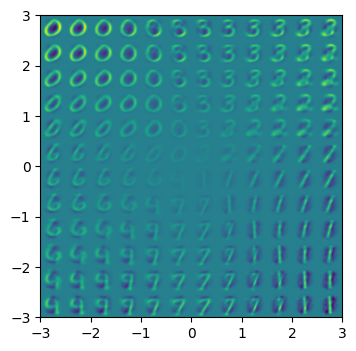


Training VLAE
Adam optimizer
Epoch 0


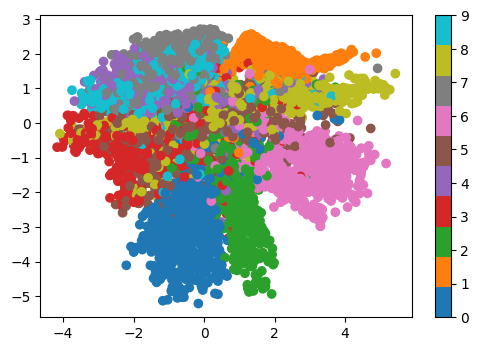

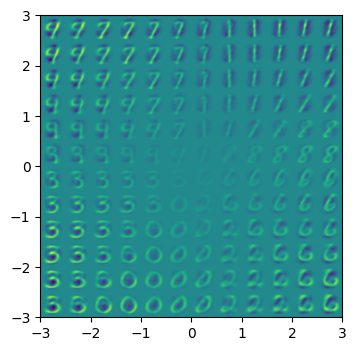


Training PCN
Adam optimizer
Epoch 0


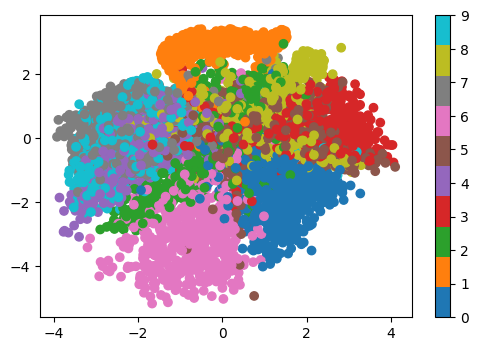

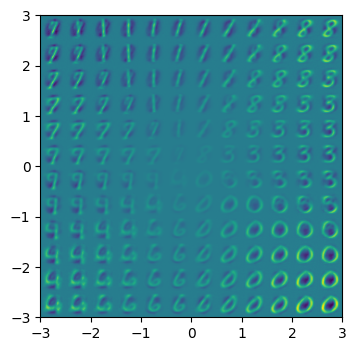


Training VPCN
Adam optimizer
Epoch 0


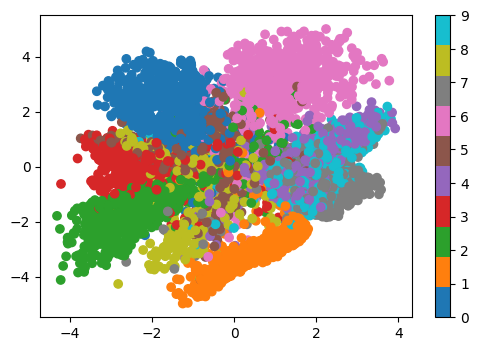

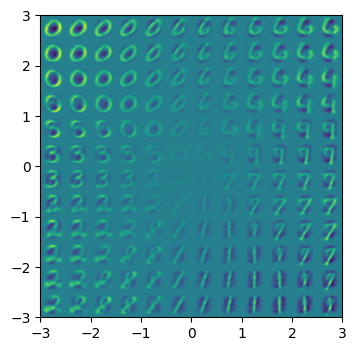

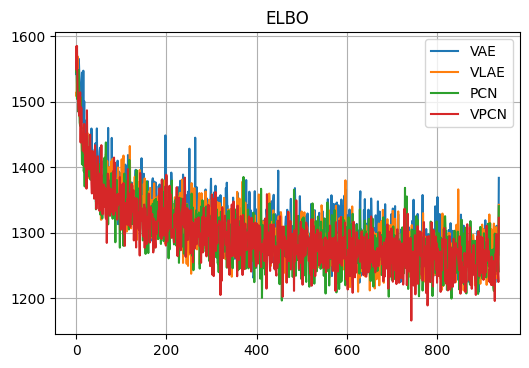

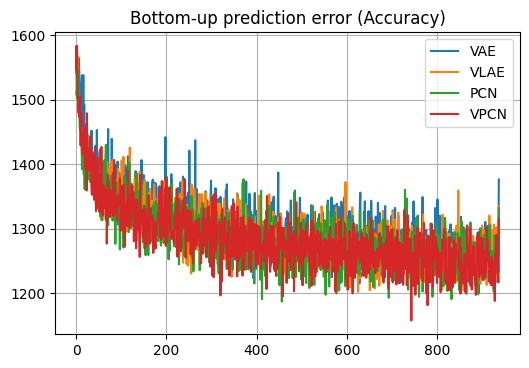

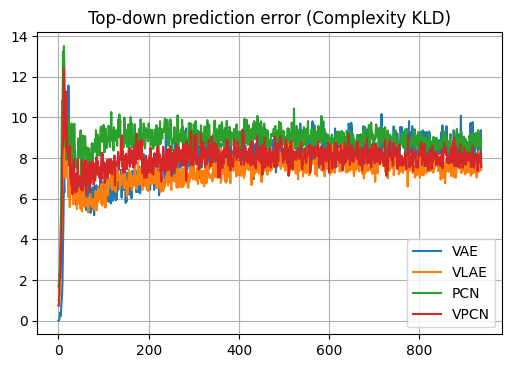

In [209]:
latent_dim = 2
models = train_all(optimiser="Adam")


Training VAE
Adam optimizer
Epoch 0

Training VLAE
Adam optimizer
Epoch 0

Training PCN
Adam optimizer
Epoch 0

Training VPCN
Adam optimizer
Epoch 0


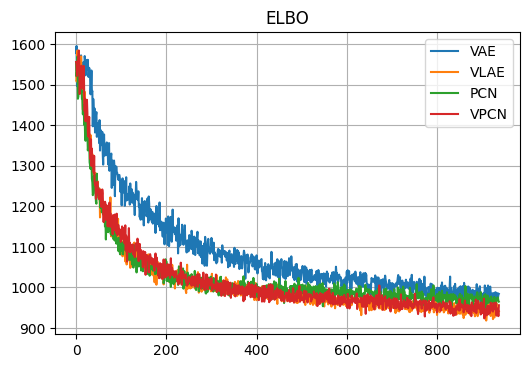

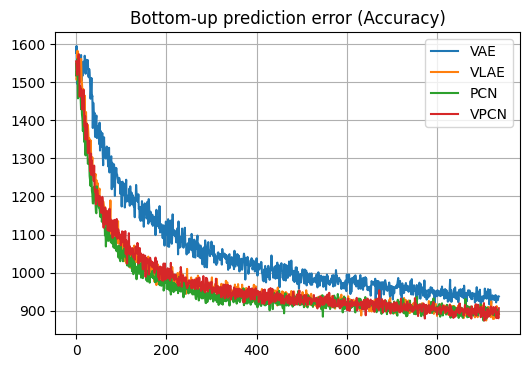

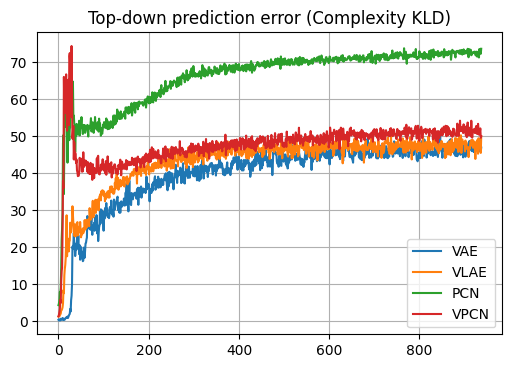

In [210]:
latent_dim = 32
models = train_all(optimiser="Adam")